# CNN

Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Load dataset

In [2]:
data_dir = r"C:\Users\apx180\Documents\CIClocal\tesis\air_pollution_data\traffic_images\MER"

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=42,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=42,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)



Found 28 files belonging to 4 classes.
Using 23 files for training.
Found 28 files belonging to 4 classes.
Using 5 files for validation.


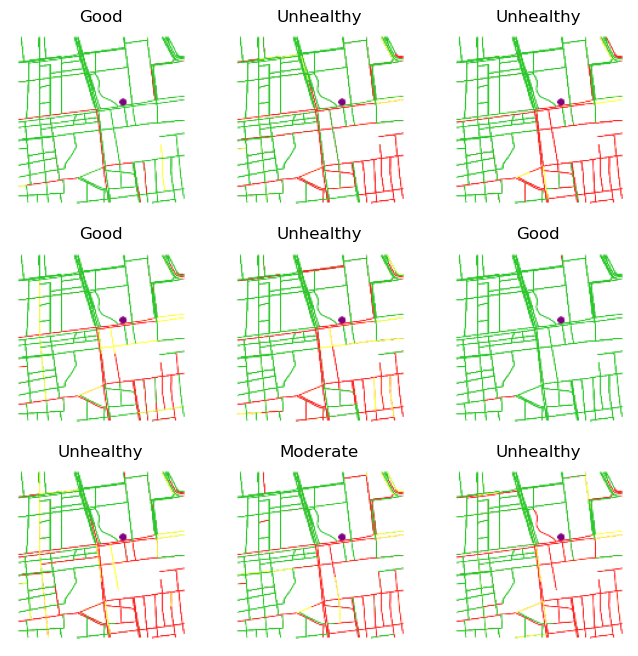

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Estructura de la CNN
Aquí se crea la estructura de la parte de **convolución** de la red, se definen las capas que utilizará. Comúnmente se van colocando de forma secuencial capas Conv2D y MaxPooling2D.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

### Juntando y entrenando el modelo

In [7]:
model.compile(optimizer='sgd',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
epochs = 40
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/40


c:\Users\apx180\AppData\Local\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1304 - loss: 1.4689 - val_accuracy: 0.2000 - val_loss: 1.4213
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4783 - loss: 1.3827 - val_accuracy: 0.2000 - val_loss: 1.3954
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4783 - loss: 1.3331 - val_accuracy: 0.2000 - val_loss: 1.3785
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4783 - loss: 1.2935 - val_accuracy: 0.2000 - val_loss: 1.3592
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4783 - loss: 1.2593 - val_accuracy: 0.2000 - val_loss: 1.3453
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4783 - loss: 1.2313 - val_accuracy: 0.2000 - val_loss: 1.3310
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4783 - loss: 1.2067 - val_accuracy: 0.2000 - val_loss: 1.3204
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4783 - loss: 1.1859 - val_accuracy: 0.2000 - val_loss: 1.3079
Epoch 

### Evaluar el modelo

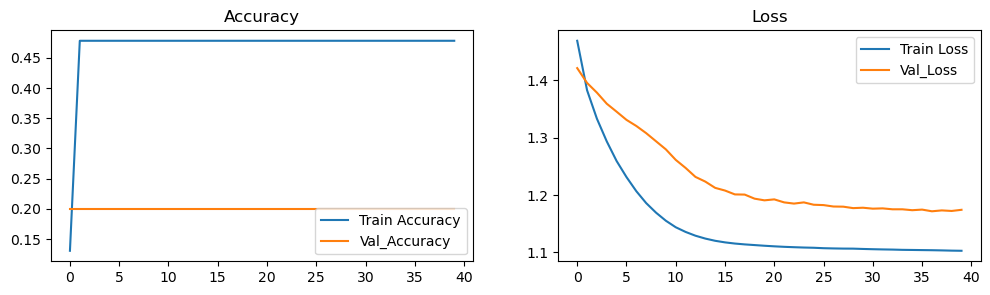

In [8]:
from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [9]:
predictions = model.predict(validation_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


In [10]:
predictions

array([[0.35894254, 0.12967715, 0.4669567 , 0.04442367],
       [0.34923354, 0.13145103, 0.47421128, 0.04510405],
       [0.3638384 , 0.12834333, 0.46394822, 0.04387004],
       [0.34228152, 0.12983504, 0.48365548, 0.04422802],
       [0.355609  , 0.12780054, 0.47303188, 0.04355859]], dtype=float32)

In [11]:
# Obtener las clases predichas
predicted_classes = np.argmax(predictions, axis=1)

# Convertir índices de clase a nombres de clase
predicted_class_names = [class_names[i] for i in predicted_classes]
true_class_names = [class_names[i] for i in labels.numpy()]

In [12]:
predicted_classes

array([2, 2, 2, 2, 2], dtype=int64)

In [13]:
predicted_class_names

['Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy', 'Unhealthy']

In [14]:

# Obtener las etiquetas verdaderas
true_labels = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
true_class_names = [class_names[i] for i in true_labels]
print(true_labels)
print(true_class_names)

[0 0 0 2 1]
['Good', 'Good', 'Good', 'Unhealthy', 'Moderate']


IndexError: list index out of range

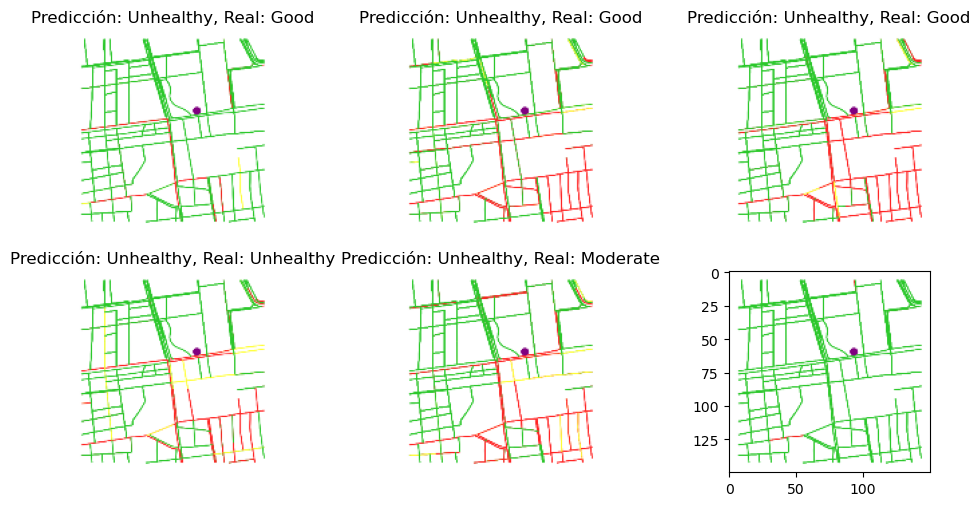

In [22]:
# Mostrar algunas imágenes junto con sus predicciones y etiquetas reales
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Predicción: {predicted_class_names[i]}, Real: {true_class_names[i]}')
    plt.axis('off')

plt.show()

In [16]:
from sklearn.metrics import accuracy_score

# Calcular la precisión
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Precisión en el conjunto de validación: {accuracy:.4f}')


Precisión en el conjunto de validación: 0.2000


In [17]:
import numpy as np

# Obtener las etiquetas verdaderas y las predicciones
y_true = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
y_pred = np.argmax(model.predict(validation_dataset), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [18]:
y_true

array([0, 0, 0, 2, 1])

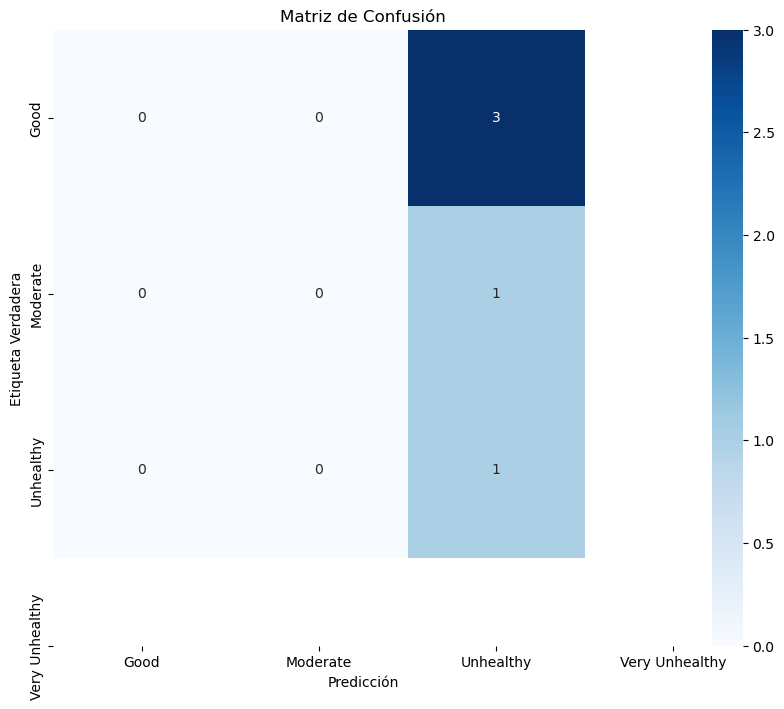

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()
